# CCT College Dublin

    Capstone Project

    MSc in Data Analytics

# Candan BAYAR

    Student ID: 2022352

    Supervisor: Kislay Raj

## Customer Purchase Prediction in the Retail Industry with Deep Learning Algorithms

## Import Libraries & Framework

In [1]:
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport
from tqdm import tqdm
import os

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.layers import Bidirectional

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf

from src.utils import get_project_config

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action="ignore")

In [2]:
%matplotlib inline

## Load Project Config & Set Variables

In [3]:
# Load Project Config
project_cfg = get_project_config("config.json",)
project_cfg

{'data': {'folderName': 'data',
  'rawData': 'data/raw',
  'processedData': 'data/processed',
  'resultData': 'data/result'},
 'reports': {'folderName': 'reports'},
 'models': {'folderName': 'models'}}

In [4]:
# Set Constant Variables

RAW_DATA_PATH = project_cfg["data"]["rawData"]
# RAW_DATA_PATH

PREPROCESSED_DATA_PATH = project_cfg["data"]["processedData"]
# PREPROCESSED_DATA_PATH

RESULT_DATA_PATH = project_cfg["data"]["resultData"]
# RESULT_DATA_PATH

REPORTS_PATH = project_cfg["reports"]["folderName"]
# REPORTS_PATH

MODELS_PATH = project_cfg["models"]["folderName"]
# MODELS_PATH

In [5]:
# Create Some Directories
os.makedirs(name=MODELS_PATH, exist_ok=True)
os.makedirs(name=REPORTS_PATH, exist_ok=True)

## Data Load

In [6]:
# Read Data
data = pd.read_excel(os.path.join(RAW_DATA_PATH, "test_data.xlsx"))
data


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,562843,23184,BULL DOG BOTTLE OPENER,1,2011-08-09 17:37:00,10.79,NaN,United Kingdom
1,578783,20973,12 PENCIL SMALL TUBE WOODLAND,10,2011-11-25 11:58:00,0.65,12748.0,United Kingdom
2,580876,22510,GINGHAM BABUSHKA DOORSTOP,2,2011-12-06 12:12:00,0.79,14071.0,United Kingdom
3,544062,84949,SILVER HANGING T-LIGHT HOLDER,1,2011-02-15 13:19:00,1.65,15311.0,United Kingdom
4,539737,22178,VICTORIAN GLASS HANGING T-LIGHT,1,2010-12-21 15:19:00,2.51,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
52972,568060,22766,PHOTO FRAME CORNICE,2,2011-09-23 13:11:00,2.95,14546.0,United Kingdom
52973,558777,22061,LARGE CAKE STAND HANGING STRAWBERY,1,2011-07-04 10:23:00,20.79,NaN,United Kingdom
52974,546172,22624,IVORY KITCHEN SCALES,2,2011-03-10 10:32:00,8.50,14156.0,EIRE
52975,575726,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1,2011-11-10 19:12:00,2.95,16791.0,United Kingdom


In [7]:
# Copy df_data
data_original = data.copy()

## Data Summary

In [8]:
#Get some information about our Dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52977 entries, 0 to 52976
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    52977 non-null  int64         
 1   StockCode    52977 non-null  object        
 2   Description  52801 non-null  object        
 3   Quantity     52977 non-null  int64         
 4   InvoiceDate  52977 non-null  datetime64[ns]
 5   UnitPrice    52977 non-null  float64       
 6   CustomerID   39549 non-null  float64       
 7   Country      52977 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 3.2+ MB


In [9]:
# Getting summary statistics
data.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
InvoiceNo,52977.0,560104.027635,536365.0,548211.0,560773.0,571899.0,581585.0,13341.442206
Quantity,52977.0,9.513732,-5368.0,1.0,3.0,10.0,5568.0,58.333336
InvoiceDate,52977,2011-07-06 00:05:12.412933888,2010-12-01 08:26:00,2011-03-30 09:06:00,2011-07-20 16:17:00,2011-10-19 14:22:00,2011-12-09 12:31:00,NaN
UnitPrice,52977.0,3.841845,0.0,1.25,2.08,4.13,4161.06,24.059268
CustomerID,39549.0,15293.676907,12347.0,13969.0,15159.0,16794.0,18287.0,1713.117802


In [10]:
# Checking how many values are missing (NaN)
data.isna().sum()

InvoiceNo          0
StockCode          0
Description      176
Quantity           0
InvoiceDate        0
UnitPrice          0
CustomerID     13428
Country            0
dtype: int64

In [11]:
# NaN percentage
data.isna().sum()*100/data.shape[0]

InvoiceNo       0.000000
StockCode       0.000000
Description     0.332220
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     25.346849
Country         0.000000
dtype: float64

In [12]:
# Dropping the NaN observations
data = data.dropna()
data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [13]:
data.select_dtypes(include='number').nunique()   #Counting the unique values in the Dataset

InvoiceNo     12838
Quantity        125
UnitPrice       225
CustomerID     3781
dtype: int64

In [14]:
# New feature: Calculating total transaction amount
data["Total_Amount"] = data["Quantity"] * data["UnitPrice"]
data.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Amount
37816,569302,23209,LUNCH BAG VINTAGE DOILY,2,2011-10-03 12:04:00,1.65,16205.0,United Kingdom,3.30
30678,574734,23217,LAUREL HEART ANTIQUE SILVER,2,2011-11-06 15:20:00,1.25,15025.0,United Kingdom,2.50
33193,548351,21035,SET/2 RED RETROSPOT TEA TOWELS,6,2011-03-30 14:51:00,3.25,13001.0,United Kingdom,19.50
43026,564843,84509B,SET OF 4 FAIRY CAKE PLACEMATS,1,2011-08-30 14:09:00,3.75,15866.0,United Kingdom,3.75
26084,556529,21239,PINK POLKADOT CUP,16,2011-06-13 11:41:00,0.85,12714.0,France,13.60


In [15]:
# Excluding cancelations
data = data[(data['Quantity'] > 0) & (data['UnitPrice'] > 0)]
data.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
InvoiceNo,39544.0,560791.674388,536365.0,549552.75,562046.0,572131.0,581585.0,13007.585397
Quantity,39544.0,12.495676,1.0,2.0,6.0,12.0,2400.0,40.545885
InvoiceDate,39544,2011-07-12 14:26:27.126239232,2010-12-01 08:26:00,2011-04-10 12:16:00,2011-08-02 10:34:00,2011-10-21 09:56:00,2011-12-09 12:31:00,NaN
UnitPrice,39544.0,3.134597,0.04,1.25,1.95,3.75,4161.06,22.357221
CustomerID,39544.0,15293.932,12347.0,13969.0,15159.0,16794.0,18287.0,1713.037116
Total_Amount,39544.0,21.741211,0.1,4.92,11.9,19.8,4992.0,75.612383


In [16]:
# Creating columns for year and month
data['Year'] = pd.DatetimeIndex(data['InvoiceDate']).year
data['Month'] = pd.DatetimeIndex(data['InvoiceDate']).month

<Axes: title={'center': 'Amount of invoices per month'}, xlabel='Year,Month'>

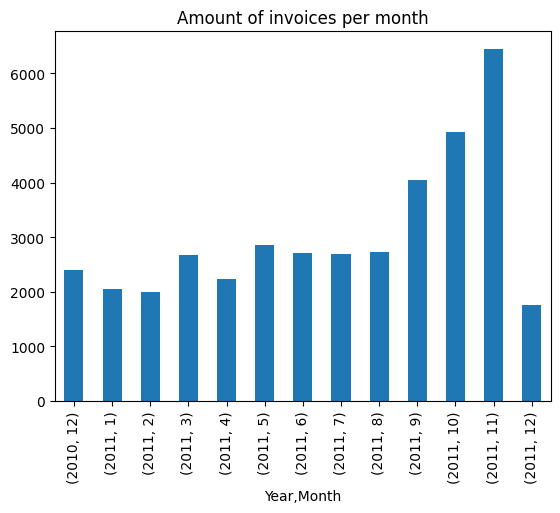

In [17]:
data.groupby(['Year', 'Month']).InvoiceNo.count().plot(kind='bar', title='Amount of invoices per month')

<Axes: title={'center': 'Amount of customers per month'}, xlabel='Year,Month'>

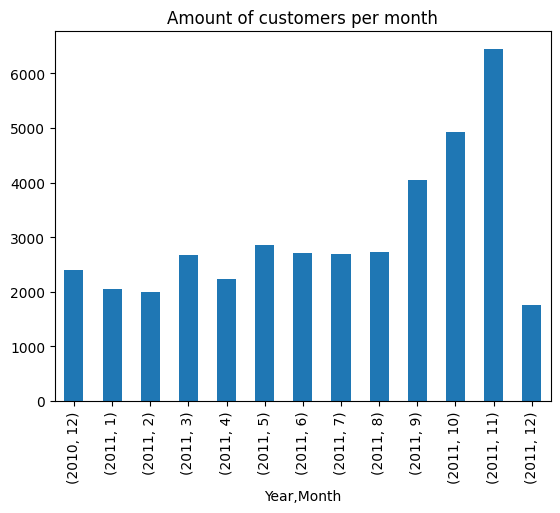

In [18]:
data.groupby(['Year', 'Month']).CustomerID.count().plot(kind='bar', title='Amount of customers per month')

In [19]:
import pandas as pd

# 'InvoiceDate' convert column to datetime format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# 'Year' ve 'Month' sütunlarını ekleyerek doldur
data['Year'] = data['InvoiceDate'].dt.year.astype(int)
data['Month'] = data['InvoiceDate'].dt.month.astype(int)

# You can drop the 'InvoiceDate' column depending on your need
# data = data.drop(columns=['InvoiceDate'])


In [20]:

# 'InvoiceDate' sütununu datetime formatına çevir
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# 'Year' ve 'Month' sütunlarını ekleyerek doldur
data['Year'] = data['InvoiceDate'].dt.year.astype(int)
data['Month'] = data['InvoiceDate'].dt.month.astype(int)

# Show monthly totals
monthly_totals = data.groupby(['Year', 'Month'])['Quantity'].sum()
print("Aylık Toplamlar:")
print(monthly_totals)

# Show yearly totals
yearly_totals = data.groupby(['Year'])['Quantity'].sum()
print("\nYıllık Toplamlar:")
print(yearly_totals)


Aylık Toplamlar:
Year  Month
2010  12       27507
2011  1        28413
      2        24016
      3        35883
      4        28400
      5        35848
      6        38672
      7        35811
      8        38816
      9        55418
      10       59379
      11       66235
      12       19731
Name: Quantity, dtype: int64

Yıllık Toplamlar:
Year
2010     27507
2011    466622
Name: Quantity, dtype: int64


In [21]:
# Show monthly totals
monthly_totals = data.groupby(['Year', 'Month']).agg({
    'Quantity': 'sum',
    'UnitPrice': 'sum',
    'CustomerID': 'nunique',  # find number of unique customers
    'Total_Amount': 'sum'
})

print("Monthly Totals:")
print(monthly_totals)

# Show yearly totals
yearly_totals = data.groupby(['Year']).agg({
    'Quantity': 'sum',
    'UnitPrice': 'sum',
    'CustomerID': 'nunique',
    'Total_Amount': 'sum'
})

print("\nAnnual Totals:")
print(yearly_totals)

Monthly Totals:
            Quantity  UnitPrice  CustomerID  Total_Amount
Year Month                                               
2010 12        27507    7786.19         639      53400.80
2011 1         28413    6431.99         572      55545.33
     2         24016    6277.88         572      45553.47
     3         35883    9212.71         756      61153.50
     4         28400    6896.29         656      41979.87
     5         35848    9359.48         822      67126.65
     6         38672    8086.42         756      65943.85
     7         35811    8082.02         749      60922.05
     8         38816    7615.65         707      60683.79
     9         55418   11551.37        1012      91576.15
     10        59379   19311.89        1119     106979.21
     11        66235   18735.90        1321     116998.07
     12        19731    4606.72         459      31871.69

Annual Totals:
      Quantity  UnitPrice  CustomerID  Total_Amount
Year                                          

In [22]:
monthly_income = data[['InvoiceDate','Total_Amount']].set_index('InvoiceDate').resample('M').sum().reset_index()
monthly_income['InvoiceDate'] = monthly_income['InvoiceDate'].dt.strftime('%b %Y')
monthly_income

,InvoiceDate,Total_Amount
0,Dec 2010,53400.80
1,Jan 2011,55545.33
2,Feb 2011,45553.47
3,Mar 2011,61153.50
4,Apr 2011,41979.87
5,May 2011,67126.65
6,Jun 2011,65943.85
7,Jul 2011,60922.05
8,Aug 2011,60683.79
9,Sep 2011,91576.15


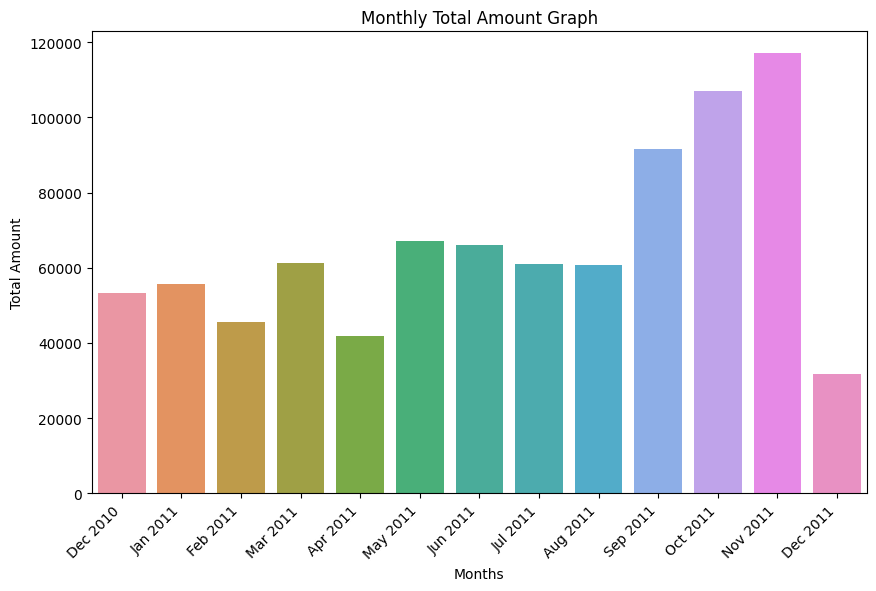

In [23]:
# An example version of the monthly_income DataFrame
monthly_income = data[['InvoiceDate','Total_Amount']].set_index('InvoiceDate').resample('M').sum().reset_index()
monthly_income['InvoiceDate'] = monthly_income['InvoiceDate'].dt.strftime('%b %Y')

# Set chart size
plt.figure(figsize=(10, 6))

# Draw bar graph with Seaborn library
sns.barplot(x='InvoiceDate', y='Total_Amount', data=monthly_income)

# Add axis labels and title
plt.xlabel('Months')
plt.ylabel('Total Amount')
plt.title('Monthly Total Amount Graph')

# Edit axis labels
plt.xticks(rotation=45, ha='right')

# Show chart
plt.show()

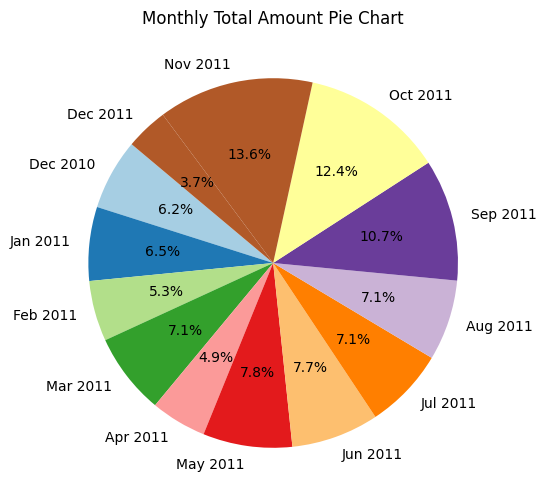

In [24]:
# An example version of the monthly_income DataFrame
monthly_income = data[['InvoiceDate','Total_Amount']].set_index('InvoiceDate').resample('M').sum().reset_index()
monthly_income['InvoiceDate'] = monthly_income['InvoiceDate'].dt.strftime('%b %Y')

# Color palette for pie chart
colors = plt.cm.Paired(range(len(monthly_income)))

# Set chart size
plt.figure(figsize=(10, 6))

# Draw a pie chart
plt.pie(monthly_income['Total_Amount'], labels=monthly_income['InvoiceDate'], autopct='%1.1f%%', colors=colors, startangle=140)

# Add title
plt.title('Monthly Total Amount Pie Chart')

# Show chart
plt.show()

In [25]:
weekly_income = data[['InvoiceDate', 'Total_Amount']].set_index('InvoiceDate').resample('W-Mon').sum().reset_index()
weekly_income.columns = ['Week', 'Total Amount']
weekly_income['Week'] = weekly_income['Week'].dt.strftime('%Y-%m-%d')

print(weekly_income)

          Week  Total Amount
0   2010-12-06      14376.47
1   2010-12-13      20740.97
2   2010-12-20      15558.10
3   2010-12-27       2725.26
4   2011-01-03          0.00
5   2011-01-10      13998.06
6   2011-01-17      22401.68
7   2011-01-24       9048.82
8   2011-01-31      10096.77
9   2011-02-07       9900.05
10  2011-02-14      10028.69
11  2011-02-21      14912.51
12  2011-02-28      10712.22
13  2011-03-07      12776.38
14  2011-03-14      10870.32
15  2011-03-21      12179.62
16  2011-03-28      15430.94
17  2011-04-04      13909.15
18  2011-04-11      11161.91
19  2011-04-18      13082.08
20  2011-04-25       7295.38
21  2011-05-02       7463.31
22  2011-05-09      15100.12
23  2011-05-16      21138.42
24  2011-05-23      18174.96
25  2011-05-30       9501.88
26  2011-06-06      13711.52
27  2011-06-13      14364.45
28  2011-06-20      19313.38
29  2011-06-27      10328.41
30  2011-07-04      14026.06
31  2011-07-11      12931.90
32  2011-07-18      10947.05
33  2011-07-25

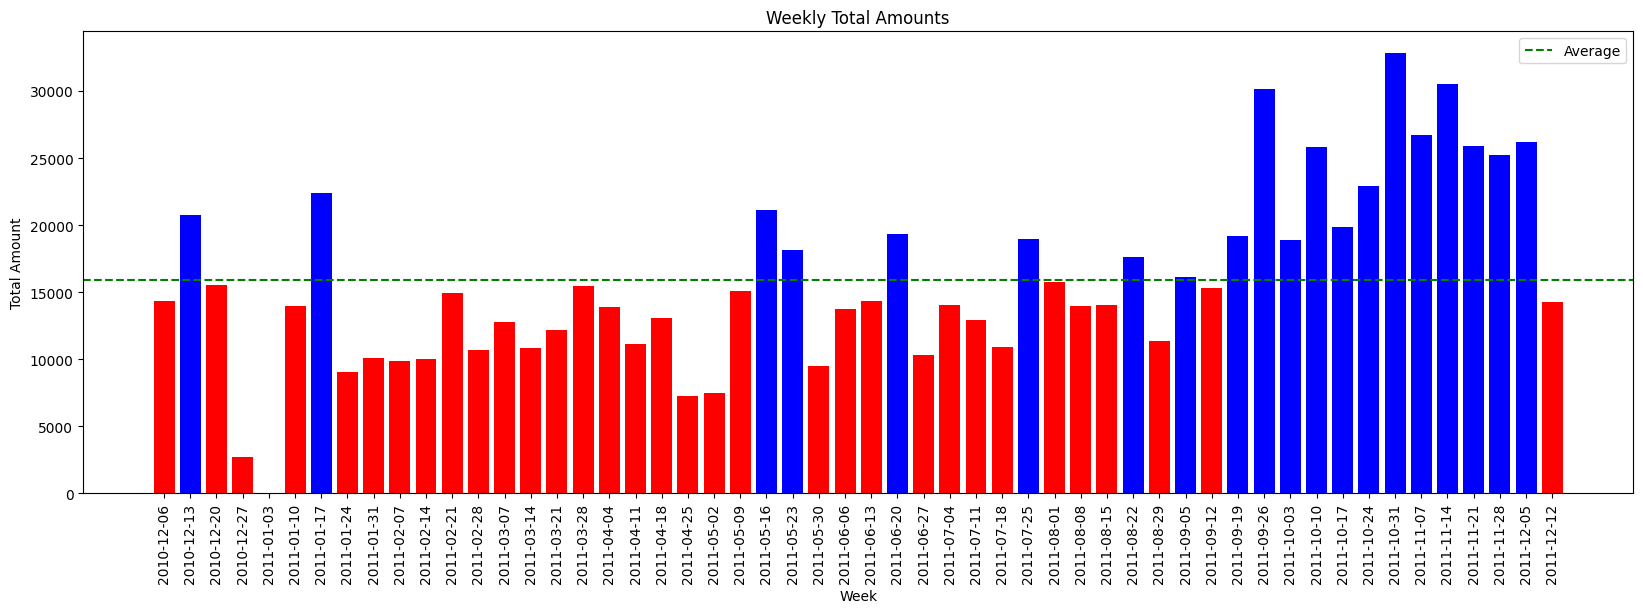

Weakly Mean= 15921.007962962965


In [26]:
# Calculation of weekly total amounts
weekly_income = data[['InvoiceDate', 'Total_Amount']].set_index('InvoiceDate').resample('W-Mon').sum().reset_index()
weekly_income.columns = ['Week', 'Total Amount']
weekly_income['Week'] = weekly_income['Week'].dt.strftime('%Y-%m-%d')

# Calculation of weekly average
weekly_mean = weekly_income['Total Amount'].mean()

# Determine colors
colors = np.where(weekly_income['Total Amount'] > weekly_mean, 'blue', 'red')

# Graphing
plt.figure(figsize=(20, 6))
plt.bar(weekly_income['Week'], weekly_income['Total Amount'], color=colors)
plt.axhline(y=weekly_mean, color='green', linestyle='--', label='Average')
plt.title('Weekly Total Amounts')
plt.xlabel('Week')
plt.ylabel('Total Amount')
plt.legend()
plt.xticks(rotation=90)


plt.show()
print("Weakly Mean=",weekly_mean)

In [27]:
data['Hour'] = data['InvoiceDate'].dt.hour
data['WeekDay']=data['InvoiceDate'].dt.weekday
data['WeekDay'] = data['WeekDay'].replace({0:'Mon', 1:'Tue',2:'Wed', 3:'Thur', 4:'Fri', 5:'Sat', 6:'Sun'})
data.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Amount,Year,Month,Hour,WeekDay
1,578783,20973,12 PENCIL SMALL TUBE WOODLAND,10,2011-11-25 11:58:00,0.65,12748.0,United Kingdom,6.5,2011,11,11,Fri


## Total sales by Weekday

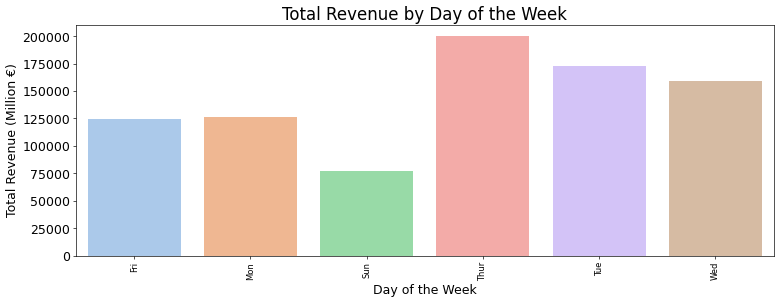

Total sales by Weekday=   WeekDay  Total_Amount
0     Fri     124602.12
1     Mon     126017.06
2     Sun      77029.08
3    Thur     200586.33
4     Tue     172402.94
5     Wed     159096.90


In [28]:
weekday = data.groupby('WeekDay').Total_Amount.sum().reset_index()

# Define the color palette
colors = sns.color_palette("pastel")

plt.figure(figsize=(15, 5), dpi=60)
sns.barplot(x='WeekDay', y='Total_Amount', data=weekday, palette=colors)

plt.xlabel('Day of the Week', fontsize=15)
plt.ylabel('Total Revenue (Million €)', fontsize=15)
plt.title('Total Revenue by Day of the Week', fontsize=20)
plt.xticks(rotation=90)
plt.yticks(fontsize=15)
plt.show()
print("Total sales by Weekday=", weekday)

## Average income by weekday

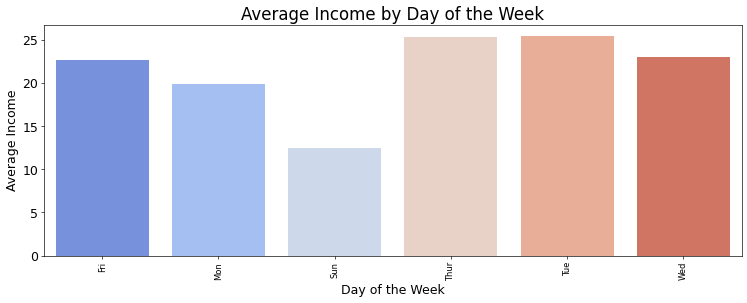

Average income by weekday=   WeekDay  Total_Amount
0     Fri     22.675545
1     Mon     19.933100
2     Sun     12.502691
3    Thur     25.358575
4     Tue     25.503393
5     Wed     23.070896


In [29]:
average_income_weekday = data.groupby('WeekDay').Total_Amount.mean().reset_index()

# Defining the color palette (Shades of Blue)
colors = sns.color_palette("coolwarm")

plt.figure(figsize=(15, 5), dpi=60)
sns.barplot(x='WeekDay', y='Total_Amount', data=average_income_weekday, palette=colors)

plt.xlabel('Day of the Week', fontsize=15)
plt.ylabel('Average Income', fontsize=15)
plt.title('Average Income by Day of the Week', fontsize=20)
plt.xticks(rotation=90)
plt.yticks(fontsize=15)
plt.show()
print("Average income by weekday=", average_income_weekday)

**Countries by Sales**

In [30]:
country_sales = data.groupby('Country').Total_Amount.sum().reset_index()

# Sort by total sales amount
country_sales = country_sales.sort_values(by='Total_Amount', ascending=False)

print(country_sales)


                 Country  Total_Amount
34        United Kingdom     696344.24
23           Netherlands      29744.75
13                France      24764.71
10                  EIRE      24098.56
14               Germany      22950.37
0              Australia      11584.84
31           Switzerland       6864.96
29                 Spain       6640.73
30                Sweden       5215.76
19                 Japan       4707.66
3                Belgium       3747.82
24                Norway       3714.59
9                Denmark       3017.48
12               Finland       2748.98
26              Portugal       2311.44
6        Channel Islands       1775.69
18                 Italy       1553.49
28             Singapore       1376.44
7                 Cyprus       1300.14
1                Austria        954.75
25                Poland        695.95
17                Israel        484.71
16               Iceland        405.23
32                   USA        382.20
15                Greece 

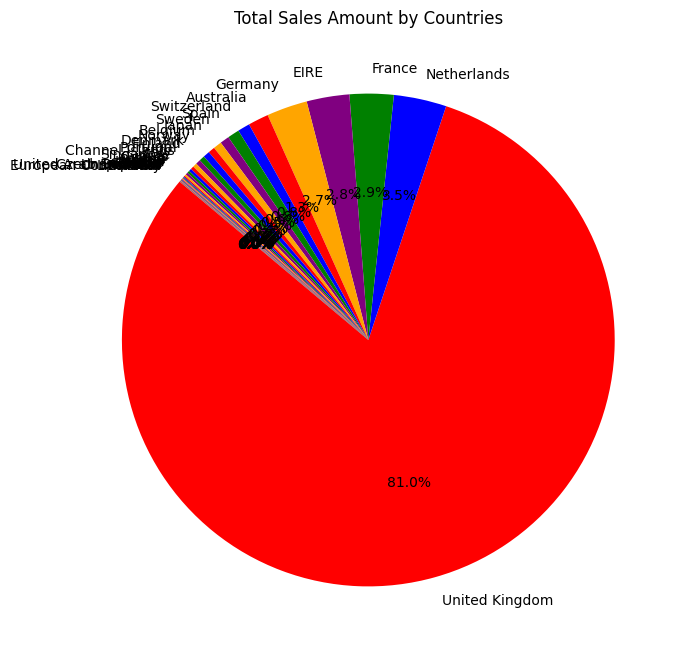

In [31]:
# Create the data frame containing the total sales amount
country_sales = data.groupby('Country').Total_Amount.sum().reset_index()

# Sort by total sales amount
country_sales = country_sales.sort_values(by='Total_Amount', ascending=False)

# Draw the pie chart
plt.figure(figsize=(10, 8))
plt.pie(country_sales['Total_Amount'], labels=country_sales['Country'], autopct='%1.1f%%', startangle=140, colors=['red', 'blue', 'green', 'purple', 'orange'])
plt.title('Total Sales Amount by Countries')
plt.show()


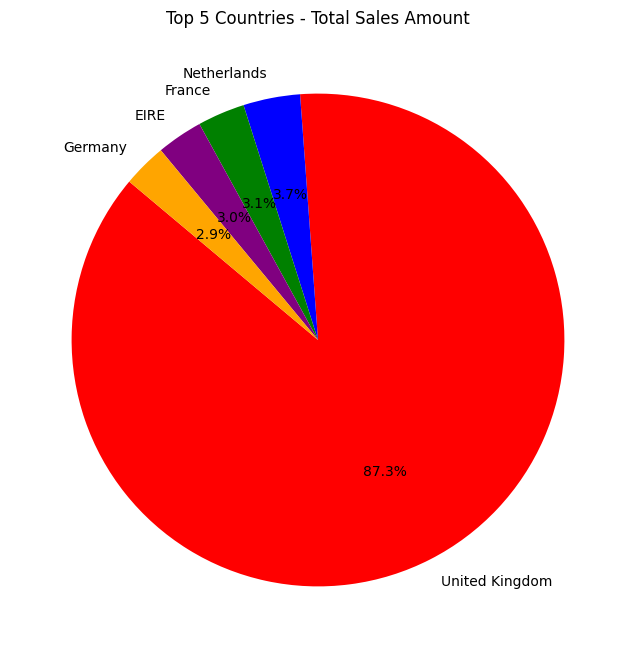

In [32]:
# Create the data frame containing the total sales amount
country_sales = data.groupby('Country').Total_Amount.sum().reset_index()

# Sort by total sales amount
top_countries = country_sales.sort_values(by='Total_Amount', ascending=False).head(5)

# Draw the pie chart
plt.figure(figsize=(10, 8))
plt.pie(top_countries['Total_Amount'], labels=top_countries['Country'], autopct='%1.1f%%', startangle=140, colors=['red', 'blue', 'green', 'purple', 'orange'])
plt.title('Top 5 Countries - Total Sales Amount')
plt.show()


In [33]:
data_original.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [34]:
data_original

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,562843,23184,BULL DOG BOTTLE OPENER,1,2011-08-09 17:37:00,10.79,NaN,United Kingdom
1,578783,20973,12 PENCIL SMALL TUBE WOODLAND,10,2011-11-25 11:58:00,0.65,12748.0,United Kingdom
2,580876,22510,GINGHAM BABUSHKA DOORSTOP,2,2011-12-06 12:12:00,0.79,14071.0,United Kingdom
3,544062,84949,SILVER HANGING T-LIGHT HOLDER,1,2011-02-15 13:19:00,1.65,15311.0,United Kingdom
4,539737,22178,VICTORIAN GLASS HANGING T-LIGHT,1,2010-12-21 15:19:00,2.51,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
52972,568060,22766,PHOTO FRAME CORNICE,2,2011-09-23 13:11:00,2.95,14546.0,United Kingdom
52973,558777,22061,LARGE CAKE STAND HANGING STRAWBERY,1,2011-07-04 10:23:00,20.79,NaN,United Kingdom
52974,546172,22624,IVORY KITCHEN SCALES,2,2011-03-10 10:32:00,8.50,14156.0,EIRE
52975,575726,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1,2011-11-10 19:12:00,2.95,16791.0,United Kingdom


In [35]:
# Set Index with Time Column
data_original.set_index('InvoiceDate', inplace=True)
data_original

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
InvoiceDate,,,,,,,
2011-08-09 17:37:00,562843,23184,BULL DOG BOTTLE OPENER,1,10.79,NaN,United Kingdom
2011-11-25 11:58:00,578783,20973,12 PENCIL SMALL TUBE WOODLAND,10,0.65,12748.0,United Kingdom
2011-12-06 12:12:00,580876,22510,GINGHAM BABUSHKA DOORSTOP,2,0.79,14071.0,United Kingdom
2011-02-15 13:19:00,544062,84949,SILVER HANGING T-LIGHT HOLDER,1,1.65,15311.0,United Kingdom
2010-12-21 15:19:00,539737,22178,VICTORIAN GLASS HANGING T-LIGHT,1,2.51,NaN,United Kingdom
...,...,...,...,...,...,...,...
2011-09-23 13:11:00,568060,22766,PHOTO FRAME CORNICE,2,2.95,14546.0,United Kingdom
2011-07-04 10:23:00,558777,22061,LARGE CAKE STAND HANGING STRAWBERY,1,20.79,NaN,United Kingdom
2011-03-10 10:32:00,546172,22624,IVORY KITCHEN SCALES,2,8.50,14156.0,EIRE


In [36]:
# Sort Data with Index
data_original.sort_index(inplace=True)
data_original

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
InvoiceDate,,,,,,,
2010-12-01 08:26:00,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,4.25,17850.0,United Kingdom
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom
2010-12-01 08:34:00,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,1.69,13047.0,United Kingdom
2010-12-01 08:45:00,536370,21035,SET/2 RED RETROSPOT TEA TOWELS,18,2.95,12583.0,France
2010-12-01 08:45:00,536370,21791,VINTAGE HEADS AND TAILS CARD GAME,24,1.25,12583.0,France
...,...,...,...,...,...,...,...
2011-12-09 12:23:00,581583,20725,LUNCH BAG RED RETROSPOT,40,1.45,13777.0,United Kingdom
2011-12-09 12:23:00,581583,85038,6 CHOCOLATE LOVE HEART T-LIGHTS,36,1.85,13777.0,United Kingdom
2011-12-09 12:31:00,581585,16016,LARGE CHINESE STYLE SCISSOR,10,0.85,15804.0,United Kingdom


In [37]:
# Index convert type to DateTime Object
data_original.index = pd.DatetimeIndex(data_original.index)
data_original

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
InvoiceDate,,,,,,,
2010-12-01 08:26:00,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,4.25,17850.0,United Kingdom
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom
2010-12-01 08:34:00,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,1.69,13047.0,United Kingdom
2010-12-01 08:45:00,536370,21035,SET/2 RED RETROSPOT TEA TOWELS,18,2.95,12583.0,France
2010-12-01 08:45:00,536370,21791,VINTAGE HEADS AND TAILS CARD GAME,24,1.25,12583.0,France
...,...,...,...,...,...,...,...
2011-12-09 12:23:00,581583,20725,LUNCH BAG RED RETROSPOT,40,1.45,13777.0,United Kingdom
2011-12-09 12:23:00,581583,85038,6 CHOCOLATE LOVE HEART T-LIGHTS,36,1.85,13777.0,United Kingdom
2011-12-09 12:31:00,581585,16016,LARGE CHINESE STYLE SCISSOR,10,0.85,15804.0,United Kingdom


In [38]:
# Show Data Information
data_original.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52977 entries, 2010-12-01 08:26:00 to 2011-12-09 12:31:00
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    52977 non-null  int64  
 1   StockCode    52977 non-null  object 
 2   Description  52801 non-null  object 
 3   Quantity     52977 non-null  int64  
 4   UnitPrice    52977 non-null  float64
 5   CustomerID   39549 non-null  float64
 6   Country      52977 non-null  object 
dtypes: float64(2), int64(2), object(3)
memory usage: 3.2+ MB


### Data Profiling

In [39]:
# Create Small Data Profile
df_data_profile = ProfileReport(data_original, title="Profiling Report", minimal=True)
df_data_profile.to_file(os.path.join(REPORTS_PATH, "Online_Retail_Dataset_Profil_Report-MinimalDataProfiling.html"))

# Create Data Profile
df_data_profile = ProfileReport(data_original, title="Profiling Report")
df_data_profile.to_file(os.path.join(REPORTS_PATH, "Online_Retail_Dataset_Profil_Report-DataProfiling.html"))

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [40]:
data_original.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'UnitPrice',
       'CustomerID', 'Country'],
      dtype='object')

In [41]:
data_original

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
InvoiceDate,,,,,,,
2010-12-01 08:26:00,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,4.25,17850.0,United Kingdom
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom
2010-12-01 08:34:00,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,1.69,13047.0,United Kingdom
2010-12-01 08:45:00,536370,21035,SET/2 RED RETROSPOT TEA TOWELS,18,2.95,12583.0,France
2010-12-01 08:45:00,536370,21791,VINTAGE HEADS AND TAILS CARD GAME,24,1.25,12583.0,France
...,...,...,...,...,...,...,...
2011-12-09 12:23:00,581583,20725,LUNCH BAG RED RETROSPOT,40,1.45,13777.0,United Kingdom
2011-12-09 12:23:00,581583,85038,6 CHOCOLATE LOVE HEART T-LIGHTS,36,1.85,13777.0,United Kingdom
2011-12-09 12:31:00,581585,16016,LARGE CHINESE STYLE SCISSOR,10,0.85,15804.0,United Kingdom


In [42]:
data_original = data_original.dropna(subset=['CustomerID'])

In [43]:
data_original['CustomerID'] = data_original['CustomerID'].fillna(-1)  # or you can assign another value

In [44]:
# Convert variables in specified columns to integer type
columns_to_convert = ['Quantity', 'CustomerID']
data_original[columns_to_convert] = data_original[columns_to_convert].astype(int)
# Check converted data
print(data_original.dtypes)

InvoiceNo        int64
StockCode       object
Description     object
Quantity         int32
UnitPrice      float64
CustomerID       int32
Country         object
dtype: object


In [45]:
data_original[columns_to_convert] = data_original[columns_to_convert].astype(int)

In [46]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data_original['Country'] = label_encoder.fit_transform(data_original['Country'].astype(str))

# Check converted data
print(data_original.dtypes)


InvoiceNo        int64
StockCode       object
Description     object
Quantity         int32
UnitPrice      float64
CustomerID       int32
Country          int32
dtype: object


In [47]:
from sklearn.preprocessing import LabelEncoder

# Create the LabelEncoder object
label_encoder = LabelEncoder()

# Transform the Description column
data_original['Description'] = label_encoder.fit_transform(data_original['Description'])

# Check the results
print(data_original['Description'])

InvoiceDate
2010-12-01 08:26:00    1133
2010-12-01 08:26:00     685
2010-12-01 08:34:00     175
2010-12-01 08:45:00    2458
2010-12-01 08:45:00    2869
                       ... 
2011-12-09 12:23:00    1526
2011-12-09 12:23:00      83
2011-12-09 12:31:00    1452
2011-12-09 12:31:00    1556
2011-12-09 12:31:00     124
Name: Description, Length: 39549, dtype: int32


In [48]:
columns_to_convert = ['Quantity', 'CustomerID']
data_original[columns_to_convert] = data_original[columns_to_convert].astype(int)

In [49]:
data_original['StockCode'] = data_original['StockCode'].astype('category')

In [50]:
data_original['StockCode'] = data_original['StockCode'].cat.codes.astype('int64')

In [51]:
# Create Logaritmic Feature for Each Columns 
extended_data = data_original.copy()

for i in extended_data.columns:
    extended_data["Log." + i] = np.log(extended_data[i] + 0.01)

In [52]:
extended_data.sample()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Log.InvoiceNo,Log.StockCode,Log.Description,Log.Quantity,Log.UnitPrice,Log.CustomerID,Log.Country
InvoiceDate,,,,,,,,,,,,,,
2011-02-16 12:47:00,544158,271,2018,12,2.1,14944,34,13.206995,5.602156,7.609867,2.48574,0.746688,9.612066,3.526655


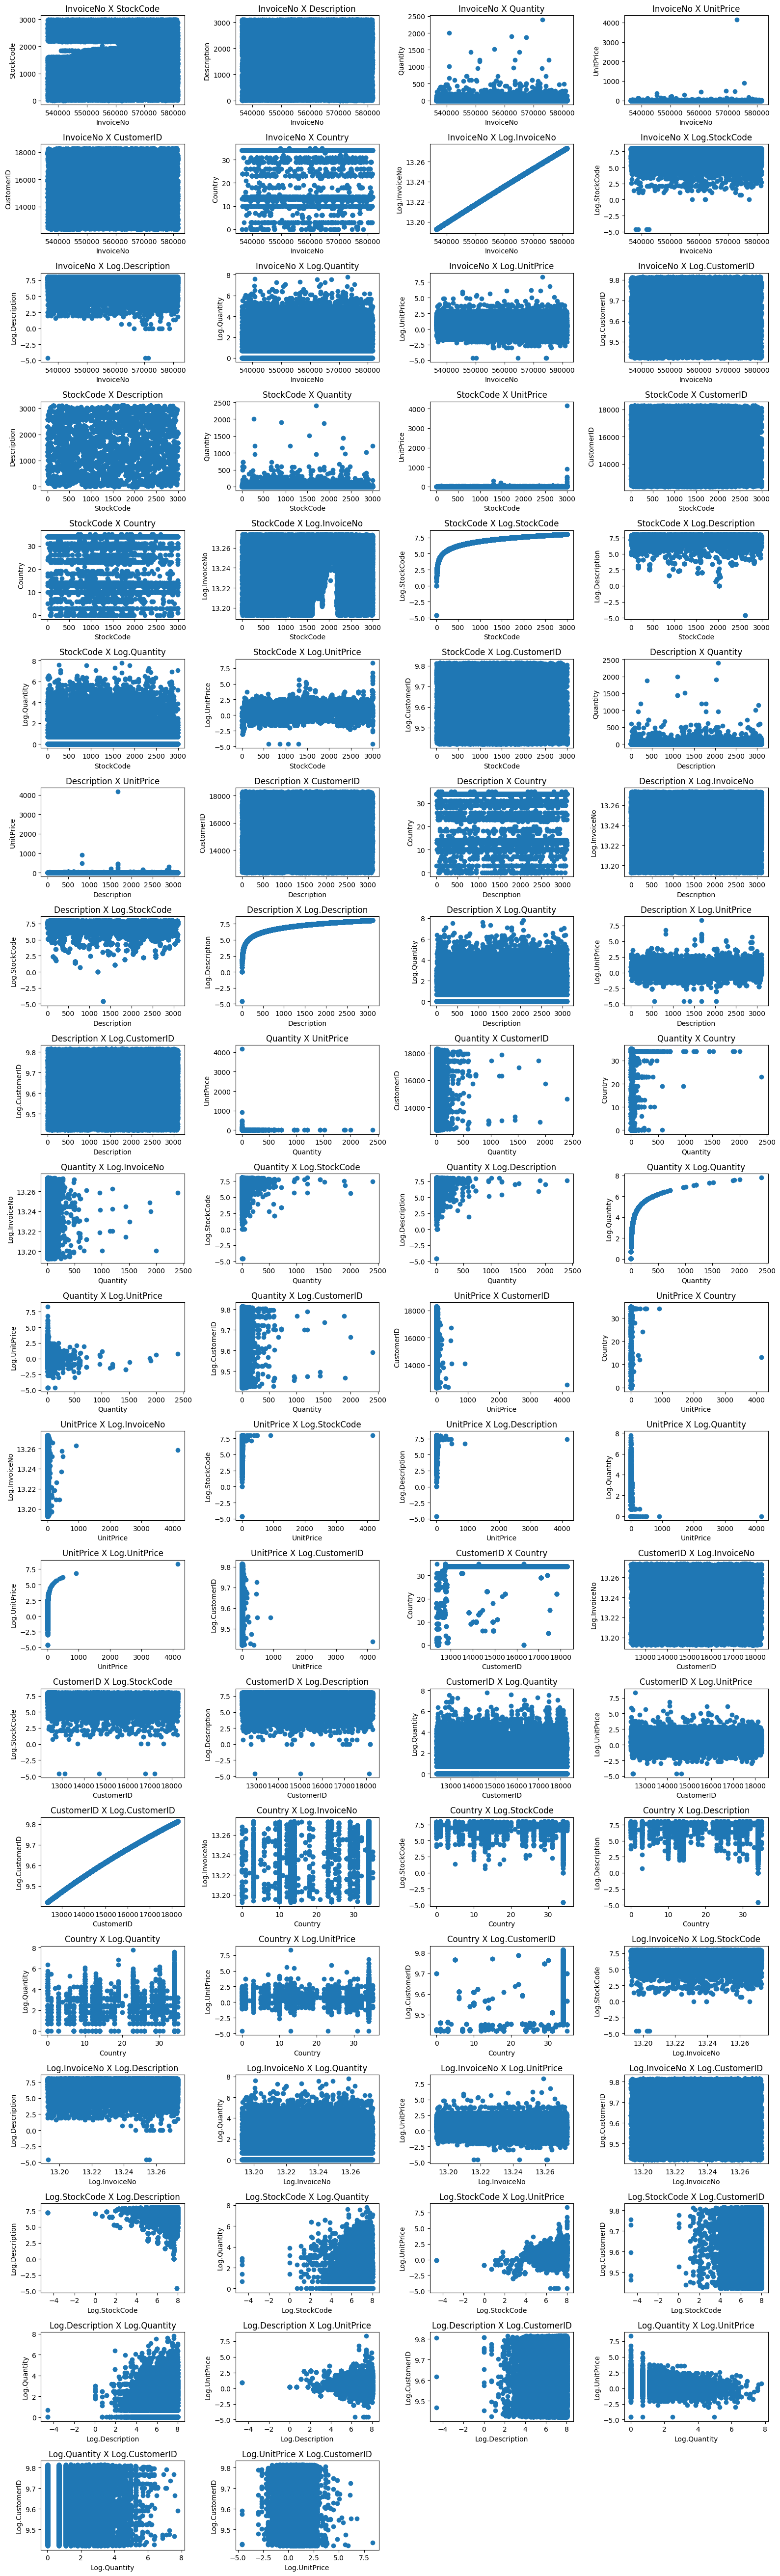

In [53]:
# Visualize Scatter Plot for Each Columns
lines = int(((len(extended_data.columns) - 1) * (len(extended_data.columns))) / 8) + 1
k = 1
subplt = plt.figure(figsize=(16, 60))

for i in range(0, len(extended_data.columns) - 1):
    for j in range(i + 1, len(extended_data.columns) - 1):
        subplt.add_subplot(lines, 4, k)
        plt.scatter(extended_data[extended_data.columns[i]], extended_data[extended_data.columns[j]])
        plt.title("{} X {}".format(extended_data.columns[i], extended_data.columns[j]))
        plt.xlabel(extended_data.columns[i])
        plt.ylabel(extended_data.columns[j])
        k += 1

plt.tight_layout()
plt.show()

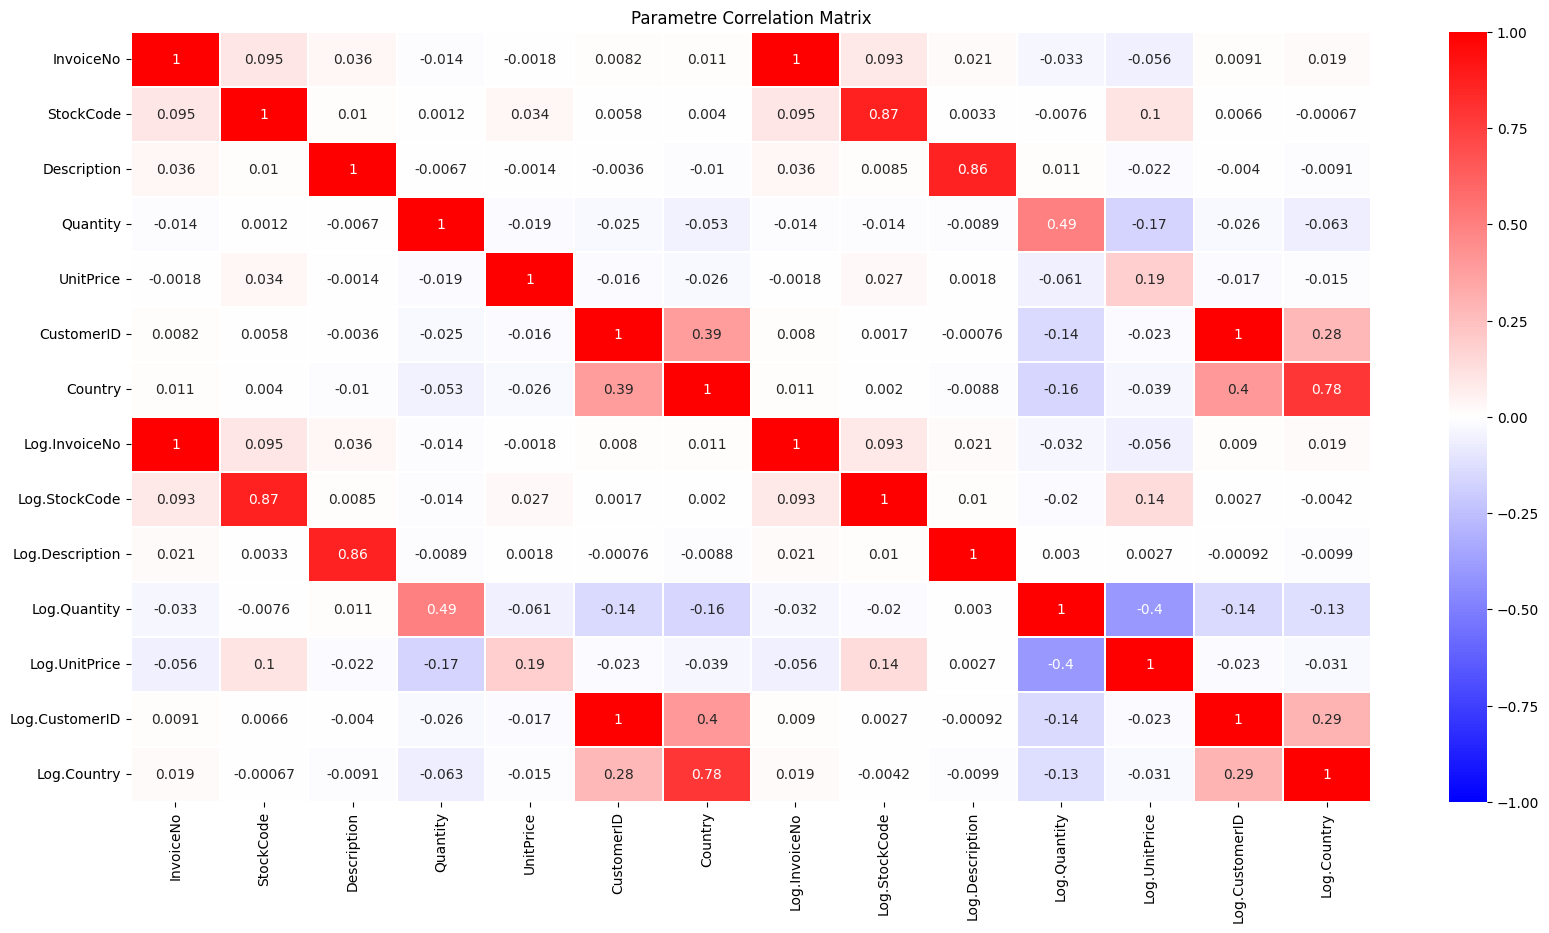

In [54]:
# Visualize Correlation Matrix

extended_corr = extended_data.corr()

plt.figure(figsize=(20, 10))
sns.heatmap(extended_corr, vmin=-1, vmax=1, cmap="bwr", annot=True, linewidth=0.1)
plt.title("Parametre Correlation Matrix")
plt.show()

### Data Splitting

In [55]:
# Split Data for Train & Test

df_train_data = data_original.iloc[:35500]
df_test_data = data_original.iloc[35500 - 12:]
df_test_original = data_original.iloc[35500:]

N_INPUT = 12    #One slice of 12 lines will be used.
N_FEATURES = 7  #how many variables "column"
BATCH_SIZE = 1  #mini-batch size to be used during training
EPOCH_SIZE = 5  #It runs the data set 5 times, if it is high, it will extend the analysis time.

In [56]:
df_train_data

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
InvoiceDate,,,,,,,
2010-12-01 08:26:00,536365,583,1133,6,4.25,17850,34
2010-12-01 08:26:00,536365,2682,685,8,2.75,17850,34
2010-12-01 08:34:00,536367,2374,175,32,1.69,13047,34
2010-12-01 08:45:00,536370,190,2458,18,2.95,12583,13
2010-12-01 08:45:00,536370,616,2869,24,1.25,12583,13
...,...,...,...,...,...,...,...
2011-11-20 14:07:00,577535,381,1638,2,0.75,14071,34
2011-11-20 14:07:00,577535,1995,2356,1,9.95,14071,34
2011-11-20 14:07:00,577535,1869,2376,1,1.25,14071,34


In [57]:
df_test_data

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
InvoiceDate,,,,,,,
2011-11-20 14:01:00,577532,2600,943,12,0.39,16666,34
2011-11-20 14:01:00,577532,504,69,3,1.25,16666,34
2011-11-20 14:01:00,577532,2216,174,9,0.21,16666,34
2011-11-20 14:01:00,577532,2254,665,3,0.85,16666,34
2011-11-20 14:04:00,577533,2728,2977,1,2.55,16877,34
...,...,...,...,...,...,...,...
2011-12-09 12:23:00,581583,81,1526,40,1.45,13777,34
2011-12-09 12:23:00,581583,2400,83,36,1.85,13777,34
2011-12-09 12:31:00,581585,15,1452,10,0.85,15804,34


In [58]:
# Show Shape of Dataframes 
df_train_data.shape, df_test_data.shape, df_test_original.shape

((35500, 7), (4061, 7), (4049, 7))

In [59]:
from keras.preprocessing.sequence import TimeseriesGenerator
# Create TimeSeriesGenerator for Training Data
train_generator = TimeseriesGenerator(df_train_data.values, df_train_data.values, length=N_INPUT, batch_size=BATCH_SIZE)

In [60]:
# Create TimeSeriesGenerator for Test Data
test_generator = TimeseriesGenerator(df_test_data.values, df_test_data.values, length=N_INPUT, batch_size=BATCH_SIZE)

In [61]:
# Split Train and Test Data
train_x = np.array([])
train_y = np.array([])
test_x = np.array([])
test_y = np.array([])

for i in range(len(train_generator)):
    a, b = train_generator[i]
    train_x = np.append(train_x, a.flatten())
    train_y = np.append(train_y, b)

for i in range(len(test_generator)):
    a, b = test_generator[i]
    test_x = np.append(test_x, a.flatten())
    test_y = np.append(test_y, b)

In [62]:
# Reshape Data Dimension Shape
train_x = train_x.reshape(-1, N_FEATURES, N_INPUT)
train_y = train_y.reshape(-1, N_FEATURES)
test_x = test_x.reshape(-1, N_FEATURES, N_INPUT)
test_y = test_y.reshape(-1, N_FEATURES)

In [63]:
# Show the shape of the Train & Test Data
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(35488, 7, 12) (35488, 7)
(4049, 7, 12) (4049, 7)


## Model Selection & Training

### LSTM Model

In [64]:
# Create LSTM Model Architecture
model_lstm = Sequential()
model_lstm.add(LSTM(64, activation='tanh', input_shape=(N_FEATURES, N_INPUT), return_sequences=True))
model_lstm.add(LSTM(32, activation='tanh', input_shape=(N_FEATURES, N_INPUT), return_sequences=False))
model_lstm.add(Dense(32, activation='elu'))
model_lstm.add(Dense(16, activation='gelu'))
model_lstm.add(Dense(train_y.shape[1]))
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 64)             19712     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 7)                 119       
                                                                 
Total params: 33831 (132.15 KB)
Trainable params: 33831 (132.15 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [65]:
# Create Directory for LSTM Model 
MODEL_DIR = project_cfg["models"]["folderName"]
MODEL_PATH = os.path.join(MODEL_DIR, "LSTM")

os.makedirs(name=MODEL_PATH, exist_ok=True)

In [66]:
# Delete all previously saved model files
for i in os.listdir(MODEL_PATH):
    file_path = os.path.join(MODEL_PATH, i)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
    except Exception as e:
        print(e)

In [67]:
# Save Model Weight per Epoch

model_dir_per_epoch = os.path.join(MODEL_PATH, 'weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5')
checkpoint = ModelCheckpoint(model_dir_per_epoch, 
                             monitor='val_loss', 
                             save_best_only=False,
                             verbose=0)

callbacks = [checkpoint]

In [68]:
# Train LSTM Model 

history = {'loss':[], 'val_loss':[]}

with tqdm(total=EPOCH_SIZE) as pbar:
    for i in range(EPOCH_SIZE):
        h = model_lstm.fit(train_x, train_y,
                           epochs=1,
                           batch_size=16,
                           validation_split=0.1,
                           callbacks=callbacks,
                           shuffle=False,
                           verbose=0)
        history['loss'].append(h.history['loss'])
        history['val_loss'].append(h.history['val_loss'])
        pbar.update(1)

100%|██████████| 5/5 [04:22<00:00, 52.55s/it]


Last Epoch Values: 
loss:  [3575731.0]
val_loss:  [1256948.5]


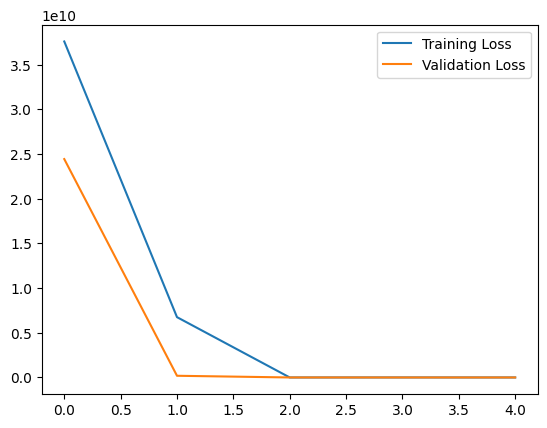

In [69]:
#  Visualization of Loss Values

print('Last Epoch Values: ')
print('loss: ', history['loss'][-1])
print('val_loss: ', history['val_loss'][-1])

loss_per_epoch = history['loss']
val_loss_per_epoch = history['val_loss']

# Visualizing Loss Values and MAE in each epoch
plt.plot(loss_per_epoch, label='Training Loss')
plt.plot(val_loss_per_epoch, label='Validation Loss')
plt.legend()
plt.show()

In [70]:
import h5py

# Load Best Performance Model
models_dir = os.path.join(MODEL_PATH, os.listdir(MODEL_PATH)[-5])

# Open the file in 'rb' (binary) mode and load it with the 'h5py' library
with h5py.File(models_dir, 'r') as file:
    model = keras.models.load_model(file)


In [71]:
# Prediction Test Set

predictions = model.predict(test_x)
predictions_lstm = pd.DataFrame(predictions, columns=df_test_original[['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'UnitPrice', 'CustomerID', 'Country']].columns, index=df_test_original.index)
predictions_lstm

127/127 [==============================] - 4s 7ms/step


,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
InvoiceDate,,,,,,,
2011-11-20 14:07:00,574063.1875,1524.744385,1760.123047,29.217932,-2.426369,15633.881836,35.565445
2011-11-20 14:07:00,574063.1875,1524.744385,1760.123047,29.217932,-2.426369,15633.881836,35.565445
2011-11-20 14:14:00,574063.1875,1524.744385,1760.123047,29.217932,-2.426369,15633.881836,35.565445
2011-11-20 14:14:00,574063.1875,1524.744385,1760.123047,29.217932,-2.426369,15633.881836,35.565445
2011-11-20 14:14:00,574063.1875,1524.744385,1760.123047,29.217932,-2.426369,15633.881836,35.565445
...,...,...,...,...,...,...,...
2011-12-09 12:23:00,574063.1875,1524.744385,1760.123047,29.217932,-2.426369,15633.881836,35.565445
2011-12-09 12:23:00,574063.1875,1524.744385,1760.123047,29.217932,-2.426369,15633.881836,35.565445
2011-12-09 12:31:00,574063.1875,1524.744385,1760.123047,29.217932,-2.426369,15633.881836,35.565445


In [72]:
# Create a DataFrame containing only certain columns
selected_columns = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'UnitPrice', 'CustomerID', 'Country']
predictions_df = pd.DataFrame(predictions, columns=selected_columns)

# Check indexes and correct if necessary
df_test_original.reset_index(drop=True, inplace=True)

# Then combine these DataFrames column wise
predictions_lstm = pd.concat([predictions_df], axis=1)
predictions_lstm

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
0,574063.1875,1524.744385,1760.123047,29.217932,-2.426369,15633.881836,35.565445
1,574063.1875,1524.744385,1760.123047,29.217932,-2.426369,15633.881836,35.565445
2,574063.1875,1524.744385,1760.123047,29.217932,-2.426369,15633.881836,35.565445
3,574063.1875,1524.744385,1760.123047,29.217932,-2.426369,15633.881836,35.565445
4,574063.1875,1524.744385,1760.123047,29.217932,-2.426369,15633.881836,35.565445
...,...,...,...,...,...,...,...
4044,574063.1875,1524.744385,1760.123047,29.217932,-2.426369,15633.881836,35.565445
4045,574063.1875,1524.744385,1760.123047,29.217932,-2.426369,15633.881836,35.565445
4046,574063.1875,1524.744385,1760.123047,29.217932,-2.426369,15633.881836,35.565445
4047,574063.1875,1524.744385,1760.123047,29.217932,-2.426369,15633.881836,35.565445


In [73]:
# Calculate MSE, RMSE and MAE performance metrics

mse = mean_squared_error(test_y, predictions)
mae = mean_absolute_error(test_y, predictions)
rmse = np.sqrt(mse)
print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)

MSE:  5132097.010307325
RMSE:  2265.4132096170283
MAE:  1202.7228906121395


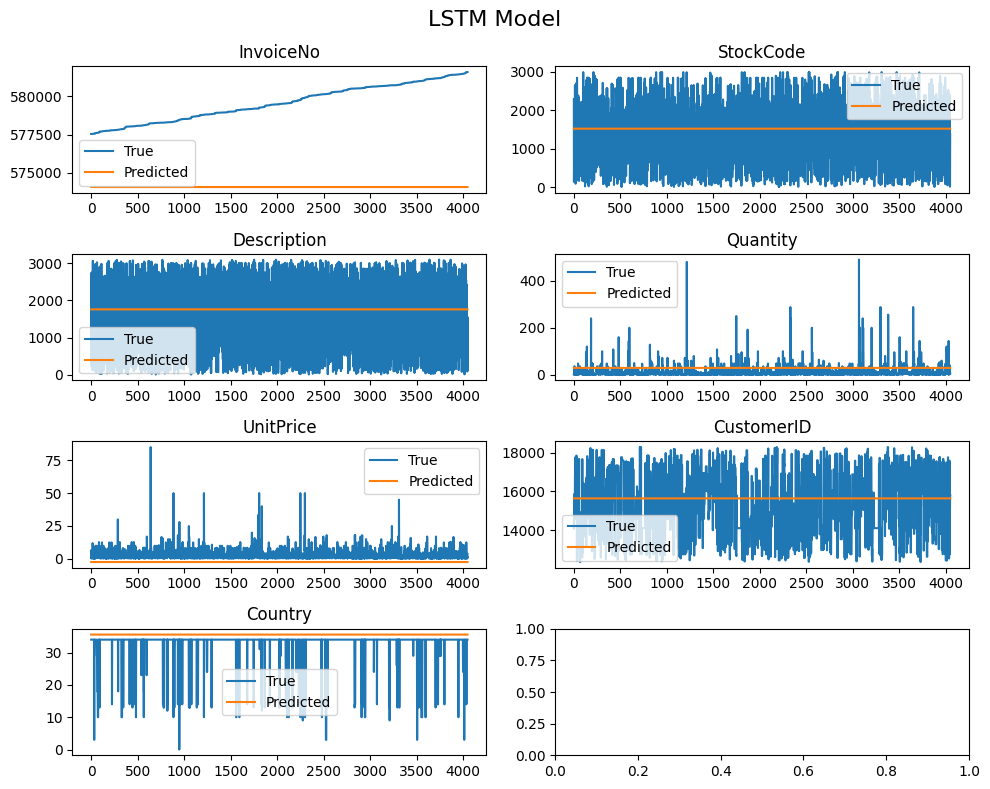

In [74]:
# Compare Actual and Prediction Values

fig, ax = plt.subplots(4, 2, figsize=(10, 8))
for i, col in enumerate(predictions_lstm.columns):
    ax[i//2, i%2].plot(df_test_original[col], label='True')
    ax[i//2, i%2].plot(predictions_lstm[col], label='Predicted')
    ax[i//2, i%2].set_title(col)
    ax[i//2, i%2].legend()
fig.suptitle('LSTM Model', fontsize=16)
plt.tight_layout()

### RNN Model

In [75]:
# Create RNN Model Architecture

model_rnn = Sequential()
model_rnn.add(SimpleRNN(64, activation='tanh', input_shape=(N_FEATURES, N_INPUT), return_sequences=True))
model_rnn.add(SimpleRNN(32, activation='tanh', input_shape=(N_FEATURES, N_INPUT), return_sequences=False))
model_rnn.add(Dense(32, activation='elu'))
model_rnn.add(Dense(16, activation='gelu'))
model_rnn.add(Dense(train_y.shape[1]))
model_rnn.compile(optimizer='adam', loss='mse')

model_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 7, 64)             4928      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 7)                 119       
                                                                 
Total params: 9735 (38.03 KB)
Trainable params: 9735 (38.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [76]:
# Create Directory for RNN Model

MODEL_PATH = os.path.join(MODEL_DIR, "RNN")
os.makedirs(name=MODEL_PATH, exist_ok=True)

In [77]:
# Delete all previously saved model files
for i in os.listdir(MODEL_PATH):
    file_path = os.path.join(MODEL_PATH, i)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
    except Exception as e:
        print(e)

In [78]:
# Save Model Weight per Epoch
model_dir_per_epoch = os.path.join(MODEL_PATH, 'weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5')
checkpoint = ModelCheckpoint(model_dir_per_epoch, 
                             monitor='val_loss', 
                             save_best_only=False,
                             verbose=0)

callbacks = [checkpoint]

In [79]:
# Train RNN Model

history = {'loss':[], 'val_loss':[]}

with tqdm(total=EPOCH_SIZE) as pbar:
    for i in range(EPOCH_SIZE):
        h = model_rnn.fit(train_x, train_y,
                          epochs=1,
                          batch_size=16,
                          validation_split=0.1,
                          callbacks=callbacks,
                          shuffle=False,
                          verbose=0)
        history['loss'].append(h.history['loss'])
        history['val_loss'].append(h.history['val_loss'])
        pbar.update(1)

100%|██████████| 5/5 [02:01<00:00, 24.27s/it]


In [80]:
# Visualization of Loss Values

print('Last Epoch Values: ')
print('loss: ', history['loss'][-1])
print('val_loss: ', history['val_loss'][-1])

loss_per_epoch = history['loss']
val_loss_per_epoch = history['val_loss']

Last Epoch Values: 
loss:  [3261790.5]
val_loss:  [1230174.25]


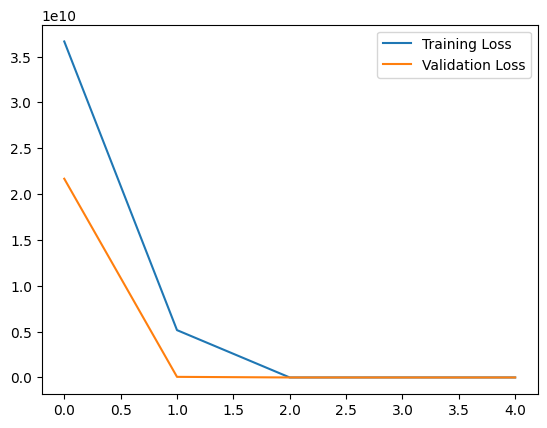

In [81]:
# Visualizing Loss Values and MAE in each epoch

plt.plot(loss_per_epoch, label='Training Loss')
plt.plot(val_loss_per_epoch, label='Validation Loss')
plt.legend()
plt.show()

In [82]:
# Load Best Performance Model
models_dir = os.path.join(MODEL_PATH, os.listdir(MODEL_PATH)[-5])
with h5py.File(models_dir, 'r') as file:
    model = keras.models.load_model(file)

In [83]:
# Prediction Test Set

predictions = model.predict(test_x)
predictions_rnn = pd.DataFrame(predictions, columns=df_test_original[['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'UnitPrice', 'CustomerID', 'Country']].columns, index=df_test_original.index)
predictions_rnn

127/127 [==============================] - 1s 3ms/step


,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
0,574112.75,1524.260498,1770.782349,30.233139,-1.743793,15628.327148,35.914547
1,574112.75,1524.260498,1770.782349,30.233139,-1.743793,15628.327148,35.914547
2,574112.75,1524.260498,1770.782349,30.233139,-1.743793,15628.327148,35.914547
3,574112.75,1524.260498,1770.782349,30.233139,-1.743793,15628.327148,35.914547
4,574112.75,1524.260498,1770.782349,30.233139,-1.743793,15628.327148,35.914547
...,...,...,...,...,...,...,...
4044,574112.75,1524.260498,1770.782349,30.233139,-1.743793,15628.327148,35.914547
4045,574112.75,1524.260498,1770.782349,30.233139,-1.743793,15628.327148,35.914547
4046,574112.75,1524.260498,1770.782349,30.233139,-1.743793,15628.327148,35.914547
4047,574112.75,1524.260498,1770.782349,30.233139,-1.743793,15628.327148,35.914547


In [84]:
# Create a DataFrame containing only certain columns
selected_columns = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'UnitPrice', 'CustomerID', 'Country']
predictions_df = pd.DataFrame(predictions, columns=selected_columns)

# Check indexes and correct if necessary
df_test_original.reset_index(drop=True, inplace=True)

# Then combine these DataFrames column wise
predictions_rnn = pd.concat([predictions_df], axis=1)
predictions_rnn

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
0,574112.75,1524.260498,1770.782349,30.233139,-1.743793,15628.327148,35.914547
1,574112.75,1524.260498,1770.782349,30.233139,-1.743793,15628.327148,35.914547
2,574112.75,1524.260498,1770.782349,30.233139,-1.743793,15628.327148,35.914547
3,574112.75,1524.260498,1770.782349,30.233139,-1.743793,15628.327148,35.914547
4,574112.75,1524.260498,1770.782349,30.233139,-1.743793,15628.327148,35.914547
...,...,...,...,...,...,...,...
4044,574112.75,1524.260498,1770.782349,30.233139,-1.743793,15628.327148,35.914547
4045,574112.75,1524.260498,1770.782349,30.233139,-1.743793,15628.327148,35.914547
4046,574112.75,1524.260498,1770.782349,30.233139,-1.743793,15628.327148,35.914547
4047,574112.75,1524.260498,1770.782349,30.233139,-1.743793,15628.327148,35.914547


In [85]:
# Calculate MSE, RMSE and MAE performance metrics

mse = mean_squared_error(test_y, predictions)
mae = mean_absolute_error(test_y, predictions)
rmse = np.sqrt(mse)
print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)

MSE:  5054661.314765506
RMSE:  2248.2573951319514
MAE:  1195.7586535259575


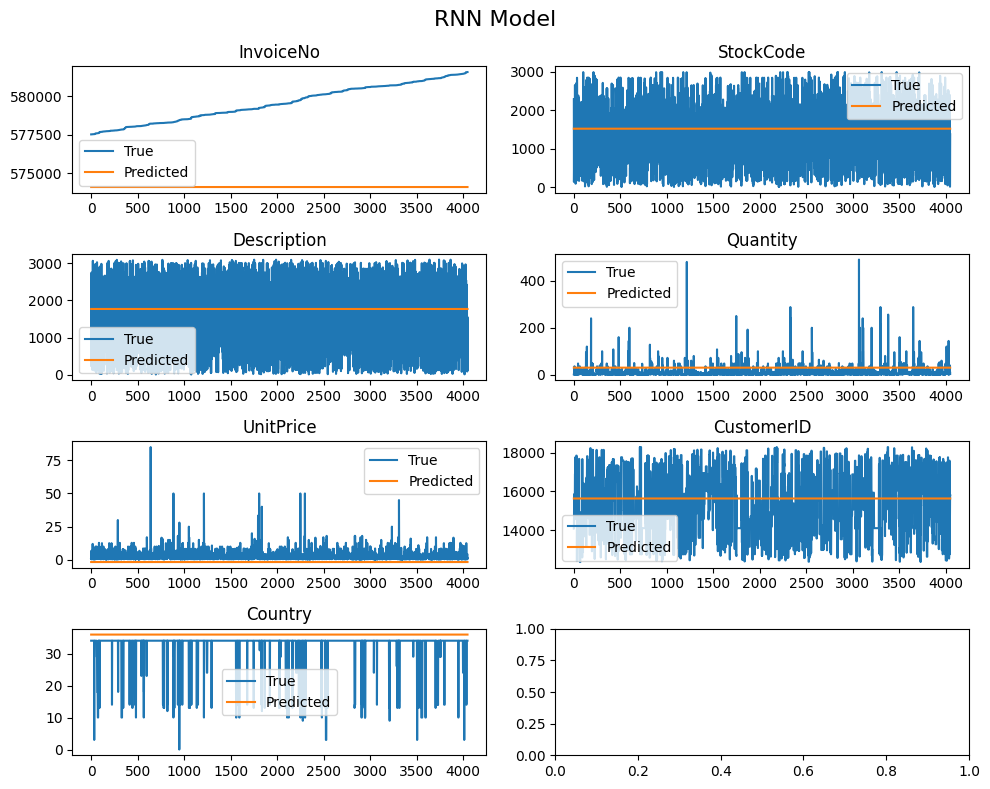

In [86]:
# Compare Actual and Prediction Values

fig, ax = plt.subplots(4,2 , figsize=(10, 8))
for i, col in enumerate(predictions_rnn.columns):
    ax[i//2, i%2].plot(df_test_original[col], label='True')
    ax[i//2, i%2].plot(predictions_rnn[col], label='Predicted')
    ax[i//2, i%2].set_title(col)
    ax[i//2, i%2].legend()
fig.suptitle('RNN Model', fontsize=16)
plt.tight_layout()

### GRU Model

In [87]:
# Create GRU Model Architecture

model_gru = Sequential()
model_gru.add(GRU(64, activation='tanh', input_shape=(N_FEATURES, N_INPUT), return_sequences=True))
model_gru.add(GRU(32, activation='tanh', input_shape=(N_FEATURES, N_INPUT), return_sequences=False))
model_gru.add(Dense(32, activation='elu'))
model_gru.add(Dense(16, activation='gelu'))
model_gru.add(Dense(train_y.shape[1]))

model_gru.compile(optimizer='adam', loss='mse')

model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 7, 64)             14976     
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dense_8 (Dense)             (None, 7)                 119       
                                                                 
Total params: 26087 (101.90 KB)
Trainable params: 26087 (101.90 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [88]:
# Create Directory for GRU Model

MODEL_PATH = os.path.join(MODEL_DIR, "GRU")
os.makedirs(name=MODEL_PATH, exist_ok=True)

In [89]:
# Delete all previously saved model files
for i in os.listdir(MODEL_PATH):
    file_path = os.path.join(MODEL_PATH, i)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
    except Exception as e:
        print(e)

In [90]:
# Save Model Weight per Epoch
model_dir_per_epoch = os.path.join(MODEL_PATH, 'weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5')
checkpoint = ModelCheckpoint(model_dir_per_epoch, 
                             monitor='val_loss', 
                             save_best_only=False,
                             verbose=0)

callbacks = [checkpoint]

In [91]:
# Train GRU Model

history = {'loss':[], 'val_loss':[]}

with tqdm(total=EPOCH_SIZE) as pbar:
    for i in range(EPOCH_SIZE):
        h = model_gru.fit(train_x, train_y,
                          epochs=1,
                          batch_size=16,
                          validation_split=0.1,
                          callbacks=callbacks,
                          shuffle=False,
                          verbose=0)
        history['loss'].append(h.history['loss'])
        history['val_loss'].append(h.history['val_loss'])
        pbar.update(1)

100%|██████████| 5/5 [05:02<00:00, 60.46s/it]


In [92]:
# Visualization of Loss Values

print('Last Epoch Values: ')
print('loss: ', history['loss'][-1])
print('val_loss: ', history['val_loss'][-1])

loss_per_epoch = history['loss']
val_loss_per_epoch = history['val_loss']

Last Epoch Values: 
loss:  [3560731.0]
val_loss:  [1255645.625]


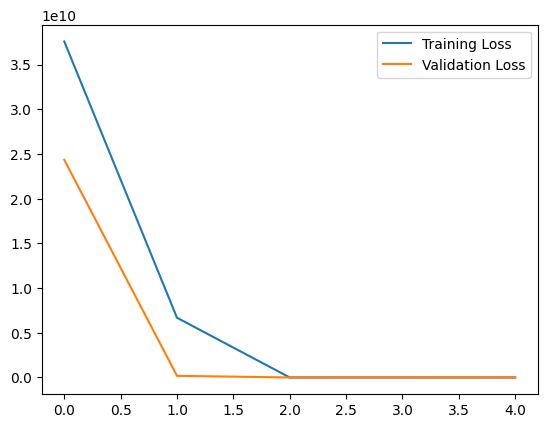

In [93]:
# Visualizing Loss Values and MAE in each epoch

plt.plot(loss_per_epoch, label='Training Loss')
plt.plot(val_loss_per_epoch, label='Validation Loss')
plt.legend()
plt.show()

In [94]:
# Load Best Performance Model
models_dir = os.path.join(MODEL_PATH, os.listdir(MODEL_PATH)[-5])
with h5py.File(models_dir, 'r') as file:
    model = keras.models.load_model(file)

In [95]:
# Prediction Test Set

predictions = model.predict(test_x)
predictions_gru = pd.DataFrame(predictions, columns=df_test_original[['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'UnitPrice', 'CustomerID', 'Country']].columns, index=df_test_original.index)
predictions_gru

127/127 [==============================] - 2s 4ms/step


,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
0,574065.5,1524.547363,1764.935059,29.64439,-2.230757,15631.514648,35.804302
1,574065.5,1524.547363,1764.935059,29.64439,-2.230757,15631.514648,35.804302
2,574065.5,1524.547363,1764.935059,29.64439,-2.230757,15631.514648,35.804302
3,574065.5,1524.547363,1764.935059,29.64439,-2.230757,15631.514648,35.804302
4,574065.5,1524.547363,1764.935059,29.64439,-2.230757,15631.514648,35.804302
...,...,...,...,...,...,...,...
4044,574065.5,1524.547363,1764.935059,29.64439,-2.230757,15631.514648,35.804302
4045,574065.5,1524.547363,1764.935059,29.64439,-2.230757,15631.514648,35.804302
4046,574065.5,1524.547363,1764.935059,29.64439,-2.230757,15631.514648,35.804302
4047,574065.5,1524.547363,1764.935059,29.64439,-2.230757,15631.514648,35.804302


In [96]:
# Create a DataFrame containing only certain columns
selected_columns = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'UnitPrice', 'CustomerID', 'Country']
predictions_df = pd.DataFrame(predictions, columns=selected_columns)

# Check indexes and correct if necessary
df_test_original.reset_index(drop=True, inplace=True)

# Then combine these DataFrames column wise
predictions_gru = pd.concat([predictions_df], axis=1)
predictions_gru

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
0,574065.5,1524.547363,1764.935059,29.64439,-2.230757,15631.514648,35.804302
1,574065.5,1524.547363,1764.935059,29.64439,-2.230757,15631.514648,35.804302
2,574065.5,1524.547363,1764.935059,29.64439,-2.230757,15631.514648,35.804302
3,574065.5,1524.547363,1764.935059,29.64439,-2.230757,15631.514648,35.804302
4,574065.5,1524.547363,1764.935059,29.64439,-2.230757,15631.514648,35.804302
...,...,...,...,...,...,...,...
4044,574065.5,1524.547363,1764.935059,29.64439,-2.230757,15631.514648,35.804302
4045,574065.5,1524.547363,1764.935059,29.64439,-2.230757,15631.514648,35.804302
4046,574065.5,1524.547363,1764.935059,29.64439,-2.230757,15631.514648,35.804302
4047,574065.5,1524.547363,1764.935059,29.64439,-2.230757,15631.514648,35.804302


In [97]:
# Calculate MSE, RMSE and MAE performance metrics

mse = mean_squared_error(test_y, predictions)
mae = mean_absolute_error(test_y, predictions)
rmse = np.sqrt(mse)
print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)

MSE:  5128479.681947641
RMSE:  2264.6146873028183
MAE:  1202.4693565975813


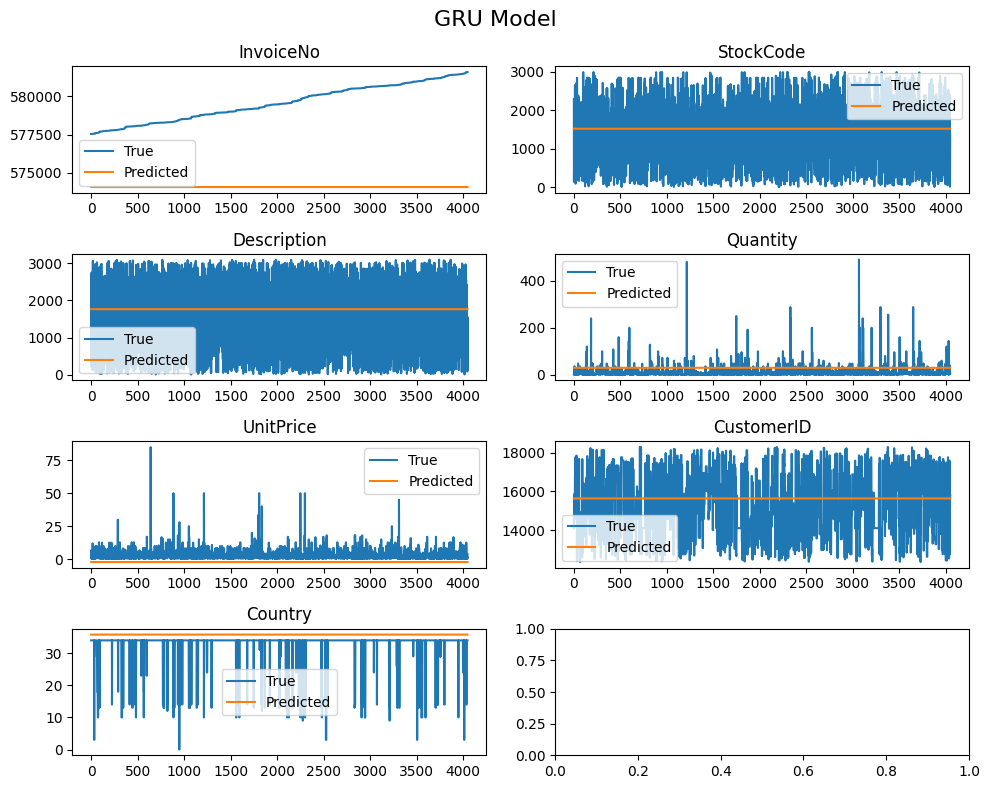

In [98]:
# Compare Actual and Prediction Values

fig, ax = plt.subplots(4, 2, figsize=(10, 8))
for i, col in enumerate(predictions_gru.columns):
    ax[i//2, i%2].plot(df_test_original[col], label='True')
    ax[i//2, i%2].plot(predictions_gru[col], label='Predicted')
    ax[i//2, i%2].set_title(col)
    ax[i//2, i%2].legend()
fig.suptitle('GRU Model', fontsize=16)
plt.tight_layout()

### Bidirectional Model

In [99]:
# Create Bidirectional Model Architecture

model_bid_lstm = Sequential()
model_bid_lstm.add(Bidirectional(LSTM(64, activation='tanh', input_shape=(N_FEATURES, N_INPUT), return_sequences=True)))
model_bid_lstm.add(Bidirectional(LSTM(32, activation='tanh', input_shape=(N_FEATURES, N_INPUT), return_sequences=False)))
model_bid_lstm.add(Dense(32, activation='elu'))
model_bid_lstm.add(Dense(16, activation='gelu'))
model_bid_lstm.add(Dense(train_y.shape[1]))
model_bid_lstm.compile(optimizer='adam', loss='mse')

model_bid_lstm.build(input_shape=(None, N_FEATURES, N_INPUT))
model_bid_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 7, 128)            39424     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 7)                 119       
                                                                 
Total params: 83367 (325.65 KB)
Trainable params: 8336

In [100]:
# Create Directory for Bidirectional Model

MODEL_PATH = os.path.join(MODEL_DIR, "Bidirectional")
os.makedirs(name=MODEL_PATH, exist_ok=True)

In [101]:
# Delete all previously saved model files
for i in os.listdir(MODEL_PATH):
    file_path = os.path.join(MODEL_PATH, i)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
    except Exception as e:
        print(e)

In [102]:
# Save Model Weight per Epoch
model_dir_per_epoch = os.path.join(MODEL_PATH, 'weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5')
checkpoint = ModelCheckpoint(model_dir_per_epoch, 
                             monitor='val_loss', 
                             save_best_only=False,
                             verbose=0)

callbacks = [checkpoint]

In [103]:
# Train Bidirectional Model
history = {'loss':[], 'val_loss':[]}

with tqdm(total=EPOCH_SIZE) as pbar:
    for i in range(EPOCH_SIZE):
        h = model_bid_lstm.fit(train_x, train_y,
                               epochs=1,
                               batch_size=16,
                               validation_split=0.1,
                               callbacks=callbacks,
                               shuffle=False,
                               verbose=0)
        history['loss'].append(h.history['loss'])
        history['val_loss'].append(h.history['val_loss'])
        pbar.update(1)

100%|██████████| 5/5 [05:09<00:00, 61.85s/it] 


In [104]:
# Visualization of Loss Values

print('Last Epoch Values: ')
print('loss: ', history['loss'][-1])
print('val_loss: ', history['val_loss'][-1])

loss_per_epoch = history['loss']
val_loss_per_epoch = history['val_loss']

Last Epoch Values: 
loss:  [2154055.25]
val_loss:  [1145800.625]


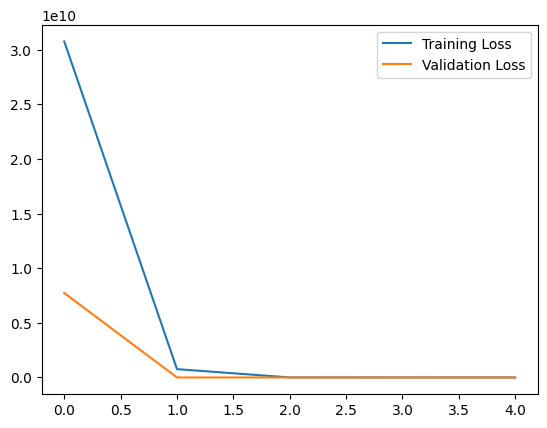

In [105]:
# Visualizing Loss Values and MAE in each epoch

plt.plot(loss_per_epoch, label='Training Loss')
plt.plot(val_loss_per_epoch, label='Validation Loss')
plt.legend()
plt.show()

In [106]:
# Load Best Performance Model
models_dir = os.path.join(MODEL_PATH, os.listdir(MODEL_PATH)[-5])
with h5py.File(models_dir, 'r') as file:
    model = keras.models.load_model(file)

In [107]:
# Prediction Test Set

predictions = model.predict(test_x)
predictions_bid_lstm = pd.DataFrame(predictions, columns=df_test_original[['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'UnitPrice', 'CustomerID', 'Country']].columns, index=df_test_original.index)
predictions_bid_lstm

127/127 [==============================] - 9s 14ms/step


,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
0,574276.0625,1502.162964,1871.787354,50.391701,-2.796296,15539.376953,29.440498
1,574276.0625,1502.162964,1871.787354,50.391701,-2.796296,15539.376953,29.440498
2,574276.0625,1502.162964,1871.787354,50.391701,-2.796296,15539.376953,29.440498
3,574276.0625,1502.162964,1871.787354,50.391701,-2.796296,15539.376953,29.440498
4,574276.0625,1502.162964,1871.787354,50.391701,-2.796296,15539.376953,29.440498
...,...,...,...,...,...,...,...
4044,574276.0625,1502.162964,1871.787354,50.391701,-2.796296,15539.376953,29.440498
4045,574276.0625,1502.162964,1871.787354,50.391701,-2.796296,15539.376953,29.440498
4046,574276.0625,1502.162964,1871.787354,50.391701,-2.796296,15539.376953,29.440498
4047,574276.0625,1502.162964,1871.787354,50.391701,-2.796296,15539.376953,29.440498


In [108]:
# Create a DataFrame containing only certain columns
selected_columns = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'UnitPrice', 'CustomerID', 'Country']
predictions_df = pd.DataFrame(predictions, columns=selected_columns)

# Check indexes and correct if necessary
df_test_original.reset_index(drop=True, inplace=True)

# Then combine these DataFrames column wise
predictions_bid_lstm = pd.concat([predictions_df], axis=1)
predictions_bid_lstm

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
0,574276.0625,1502.162964,1871.787354,50.391701,-2.796296,15539.376953,29.440498
1,574276.0625,1502.162964,1871.787354,50.391701,-2.796296,15539.376953,29.440498
2,574276.0625,1502.162964,1871.787354,50.391701,-2.796296,15539.376953,29.440498
3,574276.0625,1502.162964,1871.787354,50.391701,-2.796296,15539.376953,29.440498
4,574276.0625,1502.162964,1871.787354,50.391701,-2.796296,15539.376953,29.440498
...,...,...,...,...,...,...,...
4044,574276.0625,1502.162964,1871.787354,50.391701,-2.796296,15539.376953,29.440498
4045,574276.0625,1502.162964,1871.787354,50.391701,-2.796296,15539.376953,29.440498
4046,574276.0625,1502.162964,1871.787354,50.391701,-2.796296,15539.376953,29.440498
4047,574276.0625,1502.162964,1871.787354,50.391701,-2.796296,15539.376953,29.440498


In [109]:
# Calculate MSE, RMSE and MAE performance metrics

mse = mean_squared_error(test_y, predictions)
mae = mean_absolute_error(test_y, predictions)
rmse = np.sqrt(mse)
print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)

MSE:  4804290.524178558
RMSE:  2191.8691850059295
MAE:  1175.747322346829


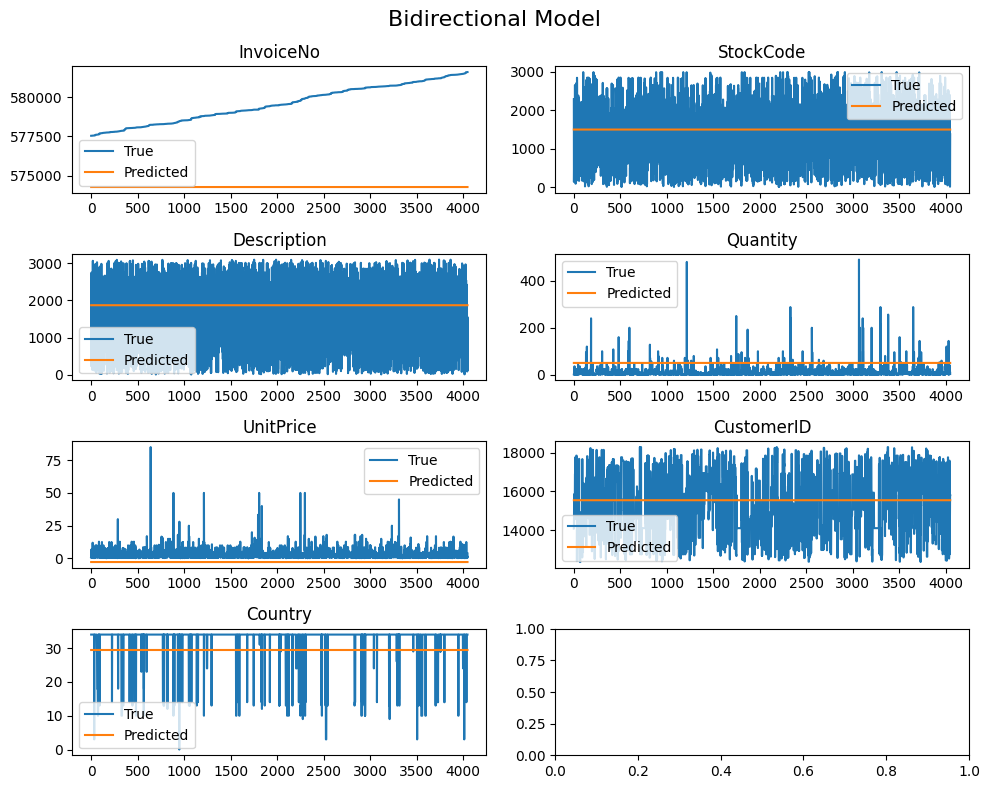

In [110]:
# Compare Actual and Prediction Values

fig, ax = plt.subplots(4, 2, figsize=(10, 8))
for i, col in enumerate(predictions_bid_lstm.columns):
    ax[i//2, i%2].plot(df_test_original[col], label='True')
    ax[i//2, i%2].plot(predictions_bid_lstm[col], label='Predicted')
    ax[i//2, i%2].set_title(col)
    ax[i//2, i%2].legend()
fig.suptitle('Bidirectional Model', fontsize=16)
plt.tight_layout()

### Evaluating Models Output

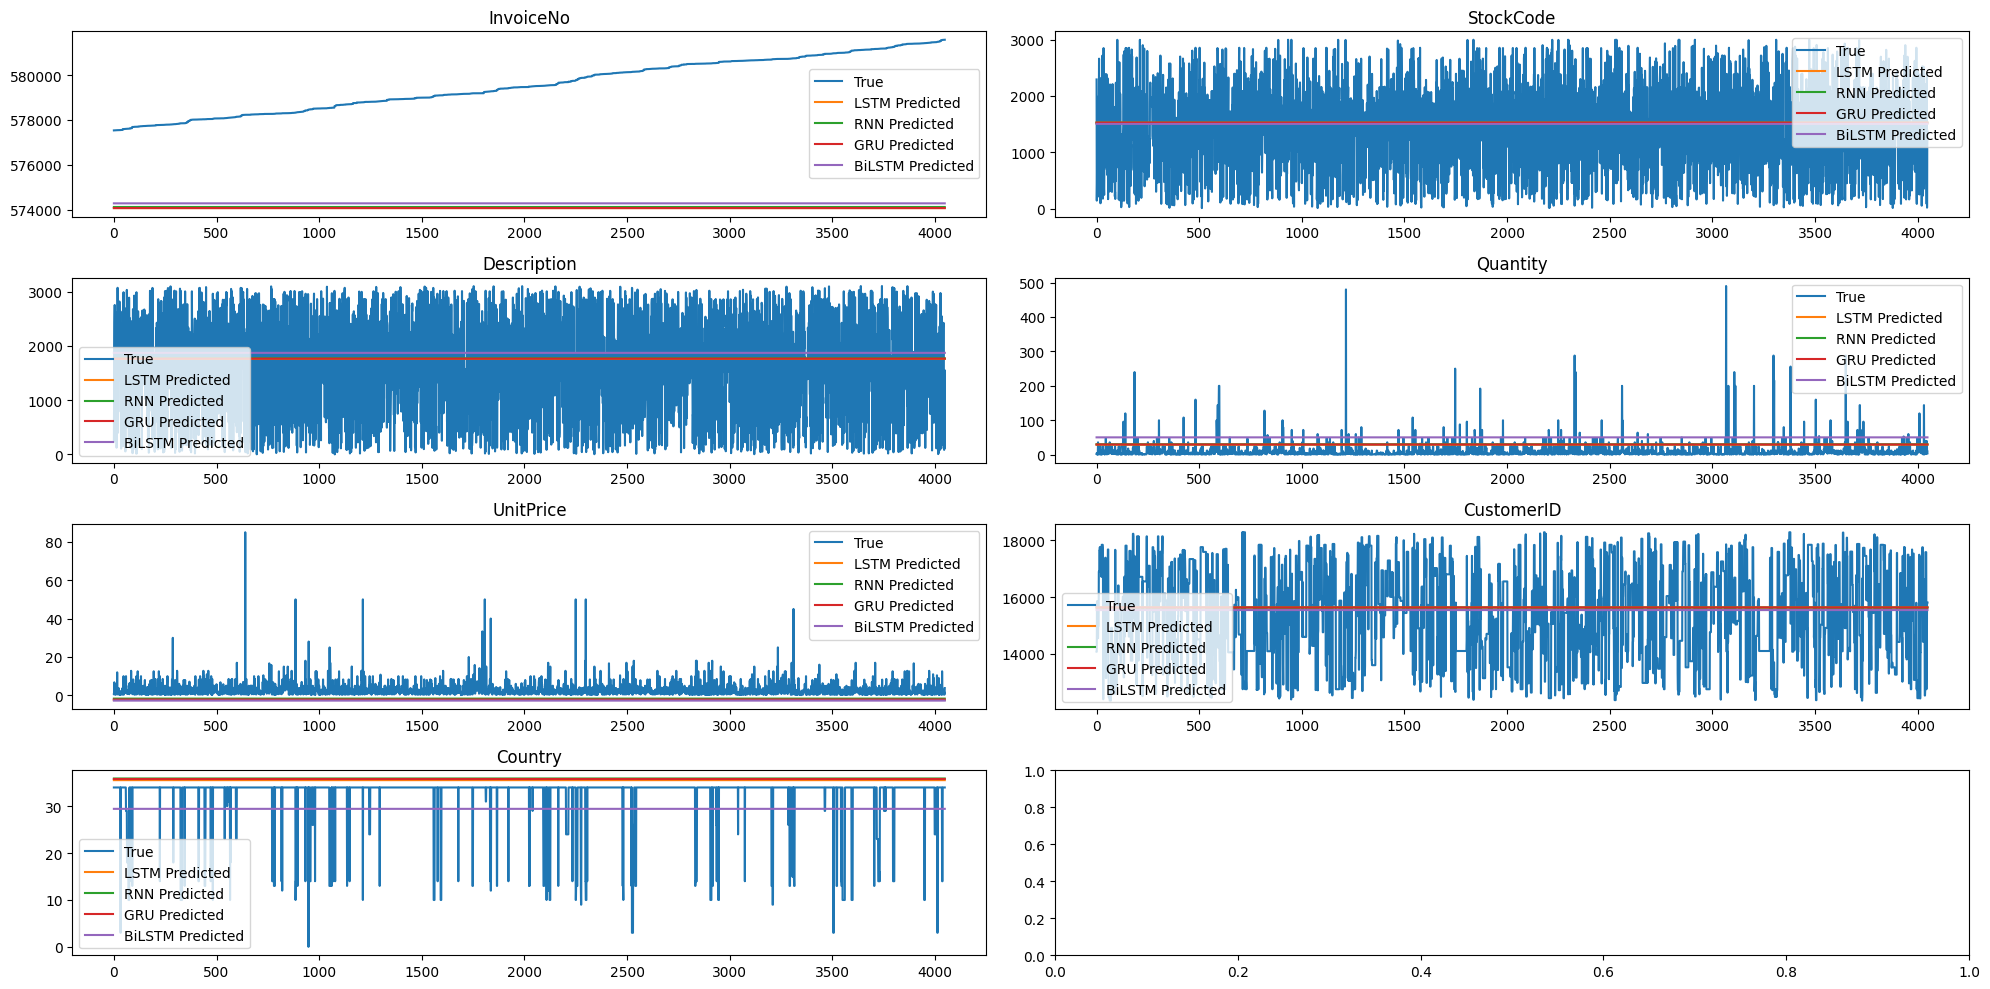

In [111]:
fig, ax = plt.subplots(4, 2, figsize=(20, 10))
for i, col in enumerate(predictions_gru.columns):
    ax[i//2, i%2].plot(df_test_original[col], label='True')
    ax[i//2, i%2].plot(predictions_lstm[col], label='LSTM Predicted')
    ax[i//2, i%2].plot(predictions_rnn[col], label='RNN Predicted')
    ax[i//2, i%2].plot(predictions_gru[col], label='GRU Predicted')
    ax[i//2, i%2].plot(predictions_bid_lstm[col], label='BiLSTM Predicted')
    ax[i//2, i%2].set_title(col)
    ax[i//2, i%2].legend()
plt.tight_layout()